# Stochastic Physics-Informed Neural ODEs (SPINODE)

A few key notes:

(1) The code here is tailored to learn neural network representations of hidden physics within stochastic differential equations of the form:

$$ dx = g_1(x,u)dt + \sqrt{2g_2(x,u)} dw, $$

where where $x$ is the system state, $u$ is an exogenous input, $w$ is a Gaussian white noise process, $g_1$ is the drift coefficient, and $g_2$ is the diffusion coefficient. Although the drift and diffusion coefficients represent the underlying physics of the stochastic system, these coefficients may not be known or even measurable in practice. As a result, $g_1$, $g_2$, or individual functions that contribute to $g_1$ and $g_2$ can comprise the the hidden physics of the above equation.

(2) The code uses unscented transform to propagate stochasticity through the above equations although other uncertainty propagation methods can be integrated into the code.

(3) Example data and results are provided for the first case study from the original paper (O'Leary et al., 2022) in the file Data.zip. The first case study is a two-state model for directed colloidal self-assembly with an exogenous input.

In [1]:
# Do not write bytecode to maintain clean directories
import sys
sys.dont_write_bytecode = True

# Import required packages and core code
import numpy as np
import os
import torch

# Ruta al directorio raíz del repo (dos niveles hacia arriba desde experiments/BS)
repo_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

# Agregar el root al sys.path si no está
if repo_root not in sys.path:
    sys.path.append(repo_root)

import src.train as train

# Specify GPU or CPU use
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Load moment data
# Mean data must be of shape [N, [nx,nu], 1]
# Covariance data must be of shape [N, nx, nx]
# Note that the general methodology can handle higher moments
# --> This code, however, only uses mean and covariance data

mean_i = np.load("data/mean_initial.npy") # mean at time step k
mean_f = np.load("data/mean_final.npy") # mean at time step k + 1
cov_i = np.load("data/cov_initial.npy") # covariance at time step k
cov_f = np.load("data/cov_final.npy") # covariance at time step k + 1

In [3]:
# Enter relevant system information
nx = 2 # state dimension
nw = 2 # noise dimension
n = nx + nw # augmented state dimension
nu = 0 # exogenous input dimension
dt = 1/252 # sampling time

In [4]:
# Prepare some of the data used to train the neural networks
# that approximate the hidden physics. Note that the "sigma" points come from
# the unscented transform function defined in "utils.py"

# First choose and create path where data will be saved
path = "results/"
os.makedirs(path, exist_ok=True)

# Now prepare data
[sigma_train,
 sigma_val,
 sigma_test,
 mean_f_train,
 mean_f_val,
 mean_f_test,
 cov_f_train,
 cov_f_val,
 cov_f_test,
 W_train,
 W_val,
 W_test,
 sigma_mu,
 sigma_std] = train.prep_data(mean_i,
                              cov_i,
                              mean_f,
                              cov_f,
                              nx,
                              nu,
                              nw,
                              path)

In [5]:
# Set training parameters for neural network that approximates g1
hidden_dim_g1 = 100 # number of hidden nodes
num_hidden_layers_g1 = 2 # number of hidden layers
num_epoch_g1 = 500 # number of epochs
solver_g1 = 'euler' # ode solver
# Note that for the provided data, the 'euler' ODE solver performs the best.
# See O'Leary, et al., 2022 for more details
rtol_g1 = 1e-7 # default value 1e-7
atol_g1 = 1e-9 # default value 1e-9

In [6]:
# Train neural network that approximates g1
model_g1 = train.train_g1(hidden_dim_g1,
                          num_hidden_layers_g1,
                          device,
                          nx,
                          nu,
                          dt,
                          num_epoch_g1,
                          sigma_train,
                          sigma_val,
                          mean_f_train,
                          mean_f_val,
                          W_train,
                          W_val,
                          solver_g1,
                          rtol_g1,
                          atol_g1,
                          path)

Epoch 0000 | Train Loss 0.000049321 | Val Loss 0.000129517
0.07669758796691895
Epoch 0001 | Train Loss 0.000047822 | Val Loss 0.000122631
0.07847428321838379
Epoch 0002 | Train Loss 0.000040470 | Val Loss 0.000115878
0.07945537567138672
Epoch 0003 | Train Loss 0.000041488 | Val Loss 0.000109554
0.09869050979614258
Epoch 0004 | Train Loss 0.000036088 | Val Loss 0.000102986
0.07847118377685547
Epoch 0005 | Train Loss 0.000032583 | Val Loss 0.000096478
0.0778501033782959
Epoch 0006 | Train Loss 0.000033556 | Val Loss 0.000089951
0.08313965797424316
Epoch 0007 | Train Loss 0.000027911 | Val Loss 0.000083313
0.08094072341918945
Epoch 0008 | Train Loss 0.000024821 | Val Loss 0.000076807
0.07809305191040039
Epoch 0009 | Train Loss 0.000022424 | Val Loss 0.000070167
0.08291316032409668
Epoch 0010 | Train Loss 0.000021857 | Val Loss 0.000063693
0.07843661308288574
Epoch 0011 | Train Loss 0.000018347 | Val Loss 0.000057284
0.07652091979980469
Epoch 0012 | Train Loss 0.000015341 | Val Loss 0.0000

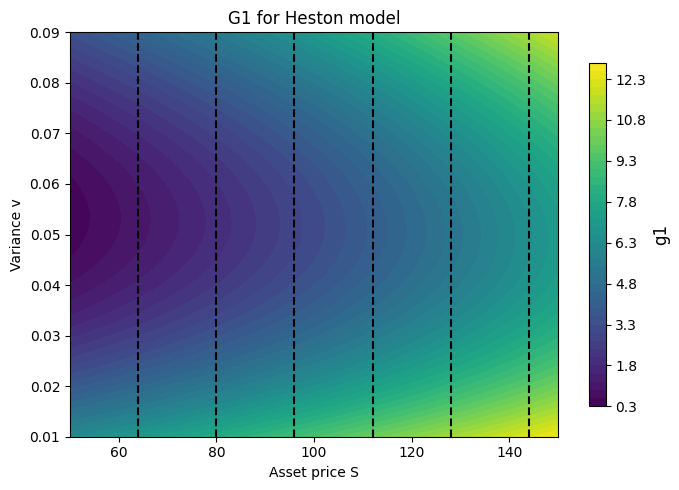

RMSE(g1) = 1.6911


In [7]:
# Reconstruct g1
rmse_g1 = train.reconstruct_Heston('g1',
                               model_g1,
                               device,
                               sigma_mu,
                               sigma_std,
                               nx,
                               nu,
                               dt,
                               path)

In [8]:
# Set training parameters for neural network that approximates g2
hidden_dim_g2 = 100 # number of hidden nodes
num_hidden_layers_g2 = 2 # number of hidden layers
num_epoch_g2 = 500 # number of epochs
solver_g2 = 'euler' # ode solver
# Note that for the provided data, the 'euler' ODE solver performs the best.
# See O'Leary, et al., 2022 for more details
rtol_g2 = 1e-15 # default value 1e-7
atol_g2 = 1e-15 # default value 1e-9

In [9]:
# Prepare target data for training neural network that approximates g2
[g2_target_train,
 g2_target_val,
 g2_target_test] = train.calc_g2_targets(sigma_train,
                                         sigma_val,
                                         sigma_test,
                                         mean_f_train,
                                         mean_f_val,
                                         mean_f_test,
                                         cov_f_train,
                                         cov_f_val,
                                         cov_f_test,
                                         nx,
                                         nu,
                                         nw,
                                         dt,
                                         sigma_mu,
                                         sigma_std,
                                         W_train,
                                         W_val,
                                         W_test,
                                         model_g1,
                                         device,
                                         solver_g1,
                                         rtol_g1,
                                         atol_g1,
                                         path)

In [10]:
# Train neural network that approximates g2
model_g2 = train.train_g2(hidden_dim_g2,
                          num_hidden_layers_g2,
                          device,
                          nx,
                          nu,
                          dt,
                          num_epoch_g2,
                          sigma_train,
                          sigma_val,
                          g2_target_train,
                          g2_target_val,
                          solver_g2,
                          rtol_g2,
                          atol_g2,
                          path)

Epoch 0000 | Train Loss 0.000936640 | Val Loss 0.001471134
0.018754243850708008
Epoch 0001 | Train Loss 0.000911478 | Val Loss 0.001445661
0.009246826171875
Epoch 0002 | Train Loss 0.000905638 | Val Loss 0.001420020
0.010578155517578125
Epoch 0003 | Train Loss 0.000887279 | Val Loss 0.001393692
0.010164022445678711
Epoch 0004 | Train Loss 0.000914644 | Val Loss 0.001366793
0.010333061218261719
Epoch 0005 | Train Loss 0.000879031 | Val Loss 0.001337665
0.00992274284362793
Epoch 0006 | Train Loss 0.000860393 | Val Loss 0.001306195
0.01159811019897461
Epoch 0007 | Train Loss 0.000810098 | Val Loss 0.001272048
0.010075807571411133
Epoch 0008 | Train Loss 0.000836658 | Val Loss 0.001235277
0.011043787002563477
Epoch 0009 | Train Loss 0.000796780 | Val Loss 0.001195274
0.011486291885375977
Epoch 0010 | Train Loss 0.000686275 | Val Loss 0.001151702
0.012447834014892578
Epoch 0011 | Train Loss 0.000718541 | Val Loss 0.001106145
0.01101827621459961
Epoch 0012 | Train Loss 0.000655354 | Val Loss

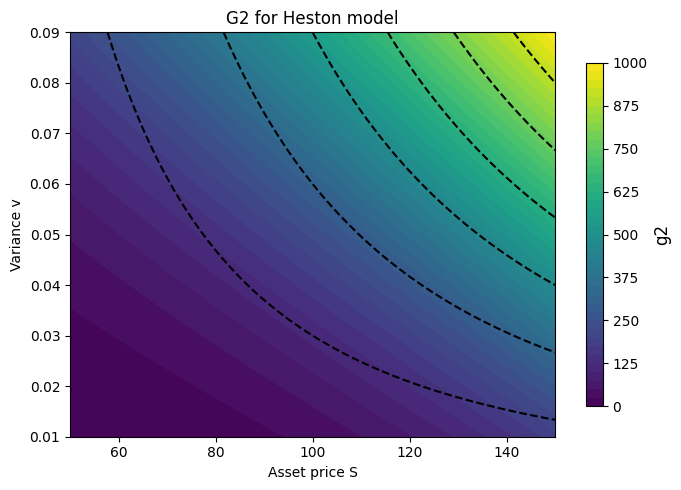

RMSE(g2) = 37.1844


In [11]:
# Reconstruct g2
rmse_g2 = train.reconstruct_Heston('g2',
                                model_g2,
                                device,
                                sigma_mu,
                                sigma_std,
                                nx,
                                nu,
                                dt,
                                path)

In [13]:
rmse_g1 = np.load("results/rmse_g1_Heston.npy")
rmse_g2 = np.load("results/rmse_g2_Heston.npy")
print("RMSE(g1):", rmse_g1)
print("RMSE(g2):", rmse_g2)

RMSE(g1): 1.6910623185595035
RMSE(g2): 37.184366708692465
